In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-detection-from-text/tweet_emotions.csv
/kaggle/input/testset/climate-pp.csv
/kaggle/input/testset/meta_nc.csv


In [2]:
!pip install emoji transformers

In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
import re
from collections import Counter, defaultdict
import emoji
from collections import Counter
from tqdm.notebook import tqdm

import random
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer,BertModel, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,precision_score,accuracy_score,f1_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
df = pd.read_csv("/kaggle/input/emotion-detection-from-text/tweet_emotions.csv")
df

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [7]:
df.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment'>

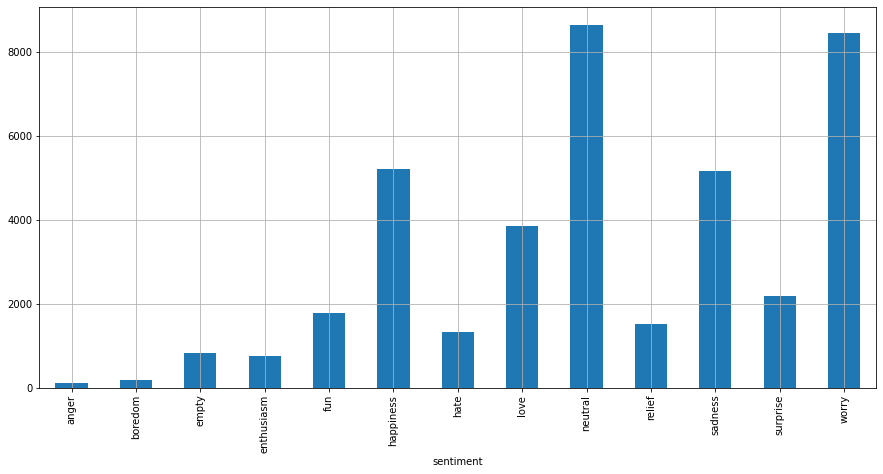

In [8]:
df.groupby('sentiment')['tweet_id'].count().plot.bar(figsize=(15,7),grid=True)

In [9]:
from sklearn.utils import resample

sent = df.sentiment.unique()

max = 3
target_majority = df[df.sentiment==sent[max]]

#min_class = [0, 2, 5, 7, 8, 10, 11, 12]

for cl in range(13):
    train_minority = df[df.sentiment==sent[cl]]
    train_minority_upsampled = resample(train_minority, replace=True, n_samples=len(target_majority), random_state=123)
    if cl == 0:
        train_upsampled = pd.concat([train_minority_upsampled, target_majority])
        #train_upsampled = pd.concat([train_upsampled, ])
    if cl>0 and cl!=max:
        train_upsampled = pd.concat([train_minority_upsampled, train_upsampled])

train_upsampled['sentiment'].value_counts() 
#'''

anger         8638
relief        8638
boredom       8638
happiness     8638
hate          8638
fun           8638
love          8638
surprise      8638
worry         8638
enthusiasm    8638
sadness       8638
empty         8638
neutral       8638
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment'>

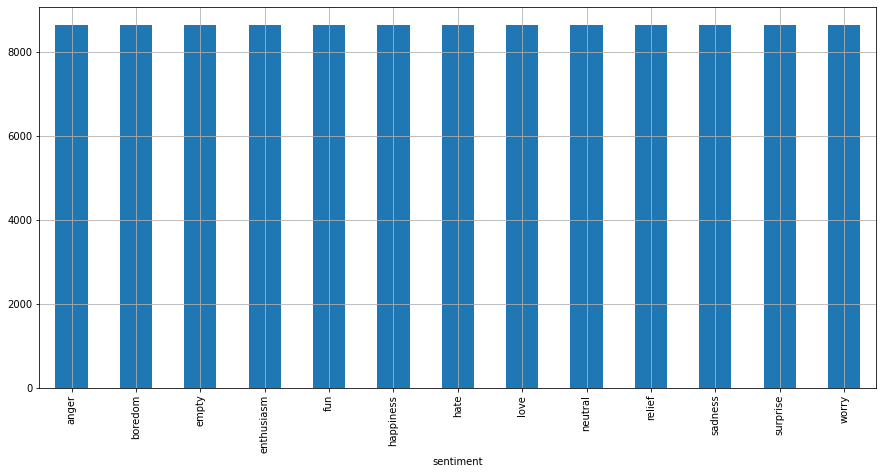

In [10]:
df = train_upsampled.sample(frac=1).reset_index(drop=True)
df.groupby('sentiment')['tweet_id'].count().plot.bar(figsize=(15,7),grid=True)


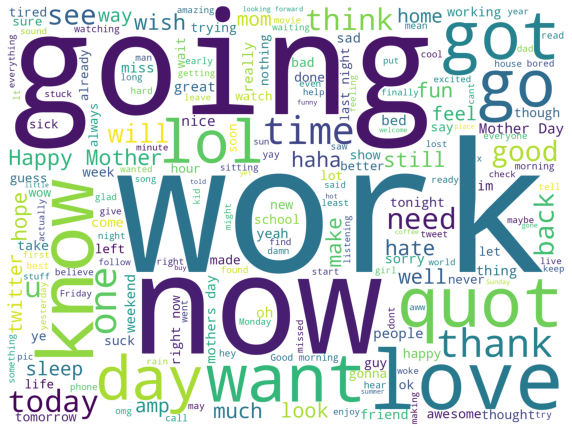

In [11]:
df_cloud = df[df['sentiment']=='neutral'] 
# join tweets to a single string
words = ' '.join(df['content'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

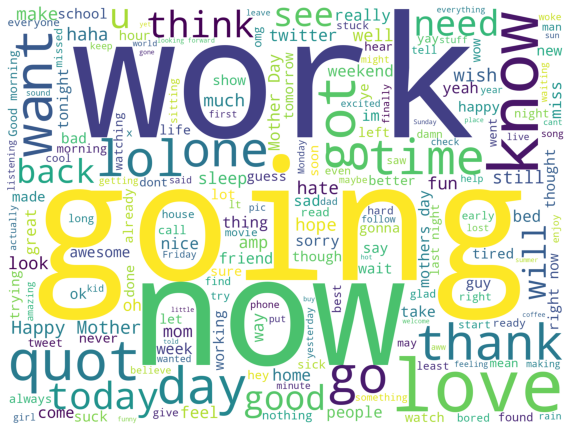

In [12]:
df_cloud = df[df['sentiment']=='happiness'] 
# join tweets to a single string
words = ' '.join(df['content'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

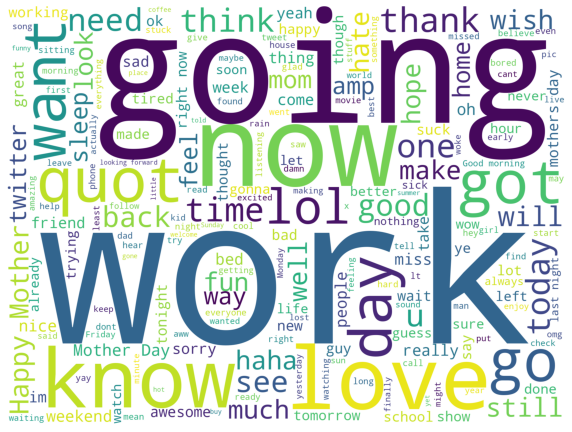

In [13]:
df_cloud = df[df['sentiment']=='worry'] 
# join tweets to a single string
words = ' '.join(df['content'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

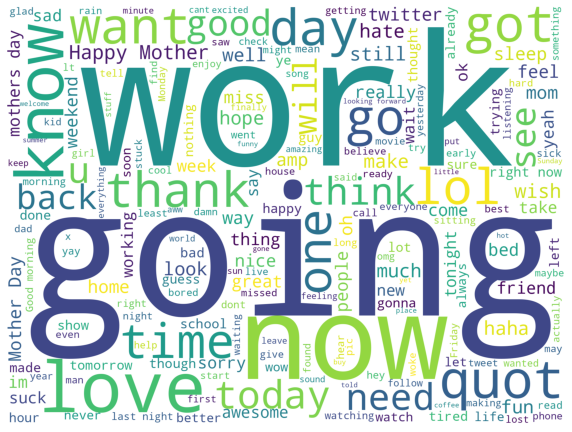

In [14]:
df_cloud = df[df['sentiment']=='sadness'] 
# join tweets to a single string
words = ' '.join(df['content'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [15]:
index = [i for i in range(len(sent.tolist()))]
label = dict(zip(sent, index))

sent = list(sent)

In [16]:
sent

['empty',
 'sadness',
 'enthusiasm',
 'neutral',
 'worry',
 'surprise',
 'love',
 'fun',
 'hate',
 'happiness',
 'boredom',
 'relief',
 'anger']

In [17]:
label

{'empty': 0,
 'sadness': 1,
 'enthusiasm': 2,
 'neutral': 3,
 'worry': 4,
 'surprise': 5,
 'love': 6,
 'fun': 7,
 'hate': 8,
 'happiness': 9,
 'boredom': 10,
 'relief': 11,
 'anger': 12}

In [18]:
df['label'] = df.sentiment.replace(label)
df.head()


,tweet_id,sentiment,content,label
0,1961183293,sadness,@thejiggerjames not the same.. Can we party t...,1
1,1753031118,happiness,@ztnewetnorb hha yeah like they have your hea...,9
2,1753219135,happiness,On my way home...then SLEEP! Seeing Amber Paci...,9
3,1752290171,happiness,@Clara_miss my best friend won tickets to see ...,9
4,1751213668,happiness,Reds win! Great end to a great day,9


In [19]:
from operator import itemgetter  

d = df.label.value_counts()
for key, value in sorted(d.items(), key = itemgetter(0), reverse = False):
    print(key, value)


0 8638
1 8638
2 8638
3 8638
4 8638
5 8638
6 8638
7 8638
8 8638
9 8638
10 8638
11 8638
12 8638


In [20]:
english_stopwords = set(stopwords.words("english"))
english_punctuations = string.punctuation

def remove_urls (text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return text

def remove_emails(text):
    text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", "",  text, flags=re.MULTILINE)
    return text

def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)

def remove_stopwords(text):
    filtered_sentence = [w for w in text.split() if not w in english_stopwords]
    return ' '.join(filtered_sentence)

def cleaning_content(line):
    if (isinstance(line, float)):
        return None
    line = line.lower()
    line.replace('\n', ' ')
    line = remove_emails(line)
    line = remove_urls(line)
    line = remove_emoji(line)
    nline = [w if '@' not in w else 'USERID' for w in line.split()]
    line = ' '.join(nline)
    line = line.replace('RT', '').replace('<LF>', '').replace('<br />','').replace('&quot;', '').replace('<url>', '').replace('USERID', '')

    
    # add spaces between punc,
    line = line.translate(str.maketrans({key: " {0} ".format(key) for key in english_punctuations}))

    # then remove punc,
    translator = str.maketrans('', '', english_punctuations)
    line = line.translate(translator)

    line = remove_stopwords(line)
    return line

def hasDigits(s):
    return any( 48 <= ord(char) <= 57  or 1632 <= ord(char) <= 1641 for char in s)


In [21]:
df.content = df.content.apply(cleaning_content)

In [22]:
df

,tweet_id,sentiment,content,label
0,1961183293,sadness,party tonight jig,1
1,1753031118,happiness,hha yeah like heart weve met shaun bradie seem...,9
2,1753219135,happiness,way home sleep seeing amber pacific tomorow be...,9
3,1752290171,happiness,best friend tickets see kiis fm,9
4,1751213668,happiness,reds win great end great day,9
...,...,...,...,...
112289,1694273821,relief,bank holiday bliss jeremy kyle without even bo...,11
112290,1964970085,boredom,ahhhhh processing shipment sooooooo much,10
112291,1694457920,relief,morning im sell 1 3 million quids worth pprope...,11
112292,1753364950,relief,thanks feeling good new forest later,11


In [23]:
df.drop('tweet_id', inplace=True, axis=1)


In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [25]:
df

,sentiment,content,label
0,sadness,party tonight jig,1
1,happiness,hha yeah like heart weve met shaun bradie seem...,9
2,happiness,way home sleep seeing amber pacific tomorow be...,9
3,happiness,best friend tickets see kiis fm,9
4,happiness,reds win great end great day,9
...,...,...,...
112289,relief,bank holiday bliss jeremy kyle without even bo...,11
112290,boredom,ahhhhh processing shipment sooooooo much,10
112291,relief,morning im sell 1 3 million quids worth pprope...,11
112292,relief,thanks feeling good new forest later,11


In [26]:
content = ' '.join(list(df.content))
words = content.split(' ')

In [27]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.content)
corpus[:10]


['party',
 'tonight',
 'jig',
 'hha',
 'yeah',
 'like',
 'heart',
 'weve',
 'met',
 'shaun']

In [28]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'day': 8183,
 'good': 6113,
 'get': 5747,
 'like': 5581,
 'go': 5263,
 'work': 5097,
 'going': 4551,
 'got': 4509,
 'today': 4479,
 'im': 4374}

<AxesSubplot:xlabel='sentiment'>

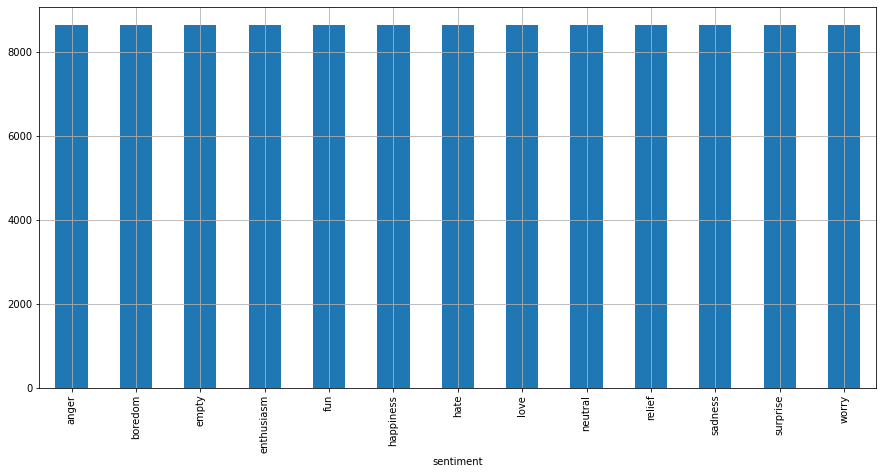

In [29]:
df.groupby('sentiment')['content'].count().plot.bar(figsize=(15,7),grid=True)

In [30]:
max_len = 100

In [31]:
class SentiDataset(Dataset):
    def __init__(self, contents, labels, tokenizer, max_len):
        self.contents = contents
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.contents)
  
    def __getitem__(self, item):
        content = str(self.contents[item])
        label = self.labels[item]
        
        # Tokenizing the texts, while also including special tokens 
        # for start and end of the text, as well as padding
        encoding = self.tokenizer.encode_plus(
          content,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt', # We return here the data as Pytorch Tensor
        )

        return {
          'content': content,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

In [32]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=random.seed(42))

print("The size of training set is : " + str(df_train.shape[0]))
print("The size of validation set is : " + str(df_val.shape[0]))

The size of training set is : 89835
The size of validation set is : 22459


In [33]:
df['data_type'] = ['not_set']*df.shape[0]


In [34]:
df

,sentiment,content,label,data_type
0,sadness,party tonight jig,1,not_set
1,happiness,hha yeah like heart weve met shaun bradie seem...,9,not_set
2,happiness,way home sleep seeing amber pacific tomorow be...,9,not_set
3,happiness,best friend tickets see kiis fm,9,not_set
4,happiness,reds win great end great day,9,not_set
...,...,...,...,...
112289,relief,bank holiday bliss jeremy kyle without even bo...,11,not_set
112290,boredom,ahhhhh processing shipment sooooooo much,10,not_set
112291,relief,morning im sell 1 3 million quids worth pprope...,11,not_set
112292,relief,thanks feeling good new forest later,11,not_set


In [35]:
df.loc[df_train.index.to_numpy(), 'data_type'] = 'train'
df.loc[df_val.index.to_numpy(), 'data_type'] = 'val'

In [36]:
df

,sentiment,content,label,data_type
0,sadness,party tonight jig,1,train
1,happiness,hha yeah like heart weve met shaun bradie seem...,9,train
2,happiness,way home sleep seeing amber pacific tomorow be...,9,train
3,happiness,best friend tickets see kiis fm,9,train
4,happiness,reds win great end great day,9,val
...,...,...,...,...
112289,relief,bank holiday bliss jeremy kyle without even bo...,11,val
112290,boredom,ahhhhh processing shipment sooooooo much,10,train
112291,relief,morning im sell 1 3 million quids worth pprope...,11,train
112292,relief,thanks feeling good new forest later,11,val


In [37]:
df.groupby(['sentiment', 'label', 'data_type']).count()

content
sentiment  label data_type         
anger      12    train         6903
                 val           1735
boredom    10    train         6949
                 val           1689
empty      0     train         6973
                 val           1665
enthusiasm 2     train         6904
                 val           1734
fun        7     train         6896
                 val           1742
happiness  9     train         6950
                 val           1688
hate       8     train         6915
                 val           1723
love       6     train         6934
                 val           1704
neutral    3     train         6856
                 val           1782
relief     11    train         6872
                 val           1766
sadness    1     train         6913
                 val           1725
surprise   5     train         6859
                 val           1779
worry      4     train         6911
                 val           1727

In [38]:
def generate_dataloader(df, tokenizer, max_len, batch_size):
    ds = SentiDataset(
        contents=df.content.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
      )

In [39]:
batch_size = 16
train_dataloader = generate_dataloader(df_train, tokenizer, max_len ,batch_size)
val_dataloader = generate_dataloader(df_val, tokenizer, max_len ,batch_size)

data = next(iter(train_dataloader))
print(data)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

{'content': ['iï¿½m smaller companies rather bigger ones itï¿½s like worked big company prove though', 'work agh really need go days go add schedule', 'super tired probably could sleep day work 12 30 9 30 today tool rental oh joy', 'dont act like impressed', 'com125 quiz feliza bugging us getting annoying', 'gay marriage legal everywhere', 'cant go fb found im alien one morning aliens allowed fb yayy congratses miss yew tew', '1 pendulum awesome 2 goodbyes suck 3 shut plz 4 toy story 3 5 jb 3d movie 2moro 6 tired 7 aaaand', 'watching girl movies night great night movie night', 'smack head', 'hey mind', 'red top tabloids build em knock em', 'well left six flags get ride wanted bummer maybe next time', 'heard brendan dj party boat weekend', 'shout sanjeev thank first follower twitter', 'oh mann likey sadly bein auctioned twpp tonight'], 'input_ids': tensor([[  101,  2462,  1094,  ...,     0,     0,     0],
        [  101,  2147, 12943,  ...,     0,     0,     0],
        [  101,  3565,  

In [40]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)


torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


In [41]:
bert = BertModel.from_pretrained("bert-base-uncased")


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [42]:
model_outs = bert(
  input_ids=data['input_ids'], 
  attention_mask=data['attention_mask']
)

pooled_output = model_outs[1]
last_hidden_state = model_outs[0]

In [43]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Adding drop out, keeping 90% of the last neurons of the raw BERT model
        self.drop = nn.Dropout(p=0.1)
        # The last linear layer for multiclass classification
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    # Forward propagation function
    def forward(self, input_ids, attention_mask):
        model_outs = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        last_hidden_state = model_outs[0]
        pooled_output = model_outs[1]
        output = self.drop(pooled_output)
        return self.out(output)

In [44]:
model = SentimentClassifier(len(sent))

# Running the classifier on GPU
model = model.to(device)

In [45]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 100])
torch.Size([16, 100])


In [46]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.0396, 0.0413, 0.0989, 0.0701, 0.0283, 0.0752, 0.0786, 0.0631, 0.0467,
         0.1197, 0.0824, 0.1569, 0.0990],
        [0.0520, 0.0426, 0.1003, 0.0937, 0.0377, 0.0744, 0.0724, 0.0396, 0.0535,
         0.0890, 0.1105, 0.1145, 0.1197],
        [0.0538, 0.0410, 0.0635, 0.1029, 0.0306, 0.0757, 0.0733, 0.0496, 0.0603,
         0.1020, 0.0818, 0.1452, 0.1204],
        [0.0379, 0.0450, 0.0812, 0.0941, 0.0275, 0.0866, 0.1031, 0.0468, 0.0392,
         0.0981, 0.0941, 0.1525, 0.0939],
        [0.0747, 0.0590, 0.0540, 0.0764, 0.0586, 0.0761, 0.0666, 0.0652, 0.0969,
         0.0647, 0.0971, 0.0985, 0.1123],
        [0.0504, 0.0508, 0.0951, 0.0756, 0.0314, 0.0776, 0.0656, 0.0483, 0.0586,
         0.1312, 0.0969, 0.1246, 0.0939],
        [0.0564, 0.0425, 0.0768, 0.0836, 0.0423, 0.0695, 0.0702, 0.0386, 0.0622,
         0.0950, 0.0985, 0.1466, 0.1178],
        [0.0762, 0.0508, 0.0584, 0.1033, 0.0398, 0.0931, 0.0562, 0.0673, 0.0712,
         0.0908, 0.0942, 0.0964, 0.1024],
        [0.0472,

In [47]:
optimizer = AdamW(model.parameters(),
                  lr=2e-5, 
                  correct_bias=False)
epochs = 4
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_dataloader)*epochs)

In [48]:
loss_fn = nn.CrossEntropyLoss().to(device)


In [49]:
# Computing multiclass precision for the outputs of the model
def compute_precision(outputs, labels):
  op = outputs.cpu()
  la = labels.cpu()
  _, preds = torch.max(op, dim=1)
  # We choose 'weighted' averaging of the precision of each label because it takes into account the imbalance of labels in our tweets dataset
  # other viable averaging methods are 'micro'
  return torch.tensor(precision_score(la, preds, average='weighted'))

In [50]:
def train(model, train_dataloader,optimizer,scheduler):

        # Reset tracking variables at the beginning of each epoch
        precision, correct_predictions, batch_counts = 0, 0, 0
        losses = []

        # Put the model into the training mode
        model.train()

  
        # For each batch of training data...
        for d in train_dataloader:
              batch_counts +=1
              # Load batch to GPU
              input_ids = d["input_ids"].to(device)
              attention_mask = d["attention_mask"].to(device)
              labels = d["labels"].to(device)

              outputs = model(input_ids=input_ids,attention_mask=attention_mask)
              
              _, preds = torch.max(outputs, dim=1)
              
              # Compute loss and accumulate the loss values

              loss = loss_fn(outputs, labels)

              correct_predictions += torch.sum(preds == labels)
              losses.append(loss.item())
              precision +=  compute_precision(outputs, labels)
            
              loss.backward()

              # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
              torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
              # Update parameters and the learning rate  
              optimizer.step()
              scheduler.step()
              optimizer.zero_grad()
          # Accuracy, loss, precision
        return correct_predictions.double() / len(df_train), np.mean(losses), precision/batch_counts

In [51]:
def eval(model, valid_dataloader, loss_fn, device):
    model = model.eval()


    correct_predictions , precision ,batch_counts = 0,0,0
    losses = []

    with torch.no_grad():
        for d in valid_dataloader:
            batch_counts += 1

            # Preparing inputs
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            # Running inference using the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
              )
            
            # Running softmax on the outputs
            _, preds = torch.max(outputs, dim=1)

            # Computing loss function
            loss = loss_fn(outputs, labels)

            # Counting the correct occurences
            correct_predictions += torch.sum(preds == labels)

            # Computing the precision (true positives/true positives + false positives) 
            # for each class and label, and find their average weighted by support 
            precision += compute_precision(outputs,labels)

            losses.append(loss.item())
    # Accuracy, loss, precision 
    return correct_predictions.double() / len(df_val), np.mean(losses), precision/batch_counts 

In [52]:
!nvidia-smi

Mon Nov 29 23:58:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    33W / 250W |   2559MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [53]:
history = defaultdict(list)
b_accuracy = 0

for epoch in range(epochs):
  
  print(f'Epoch {epoch + 1}/{epochs}')
  print('-' * 20)

  train_acc, train_loss, train_preci = train(
        model,
        train_dataloader,    
        optimizer, 
        scheduler,
      )
  print(f"Train : Loss {train_loss}, Accuracy : {train_acc}, Precision : {train_preci}")

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['train_precision'].append(train_preci)

  val_acc, val_loss, val_preci = eval(
        model,
        val_dataloader,
        loss_fn, 
        device, 
      )

  print(f'Val : Loss :{val_loss}, Accuracy : {val_acc}, Precision : {val_preci}')  
  print()

  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  history['val_precision'].append(val_preci)
  
  if val_acc > b_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    b_accuracy = val_acc

Epoch 1/4
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train : Loss 2.569027013940038, Accuracy : 0.0776534758167752, Precision : 0.048965049494880085


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val : Loss :2.5657013900938876, Accuracy : 0.07756356026537245, Precision : 0.010411102207977209

Epoch 2/4
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train : Loss 2.5667201275286247, Accuracy : 0.07627316747370179, Precision : 0.0531165386199333


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val : Loss :2.5650738783371754, Accuracy : 0.07921100672336258, Precision : 0.010795371768383131

Epoch 3/4
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train : Loss 2.5663166738681675, Accuracy : 0.07537151444314577, Precision : 0.05961414082170428


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val : Loss :2.5649500015454416, Accuracy : 0.07921100672336258, Precision : 0.010795371768383131

Epoch 4/4
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train : Loss 2.5659232666528555, Accuracy : 0.0756498024155396, Precision : 0.07552508986141004


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val : Loss :2.565116591772802, Accuracy : 0.07756356026537245, Precision : 0.010411102207977209



In [54]:
b_accuracy

tensor(0.0792, device='cuda:0', dtype=torch.float64)

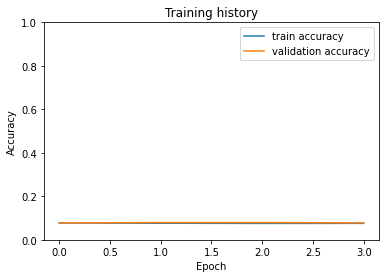

In [55]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [56]:
model = SentimentClassifier(len(sent))
model.load_state_dict(torch.load('./best_model_state.bin'))
model = model.to(device)

In [57]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [58]:
df_test1 = pd.read_csv("/kaggle/input/testset/climate-pp.csv")
df_test2 = pd.read_csv("/kaggle/input/testset/meta_nc.csv")

In [59]:
df_test1

,DocText,DocDate
0,400 private jets too the climate change summit...,2021-11-02 23:23:58
1,“Covid” restrictions are so much like “Climate...,2021-11-02 23:22:22
2,Thank you to everybody who made this a success...,2021-11-02 23:09:11
3,anti-climate change **** deserve love and respect,2021-11-02 22:27:22
4,Very alarming ang effects ng climate change es...,2021-11-02 22:26:23
...,...,...
361,Always love @amelia_draper on @nbcwashington p...,2021-03-16 22:42:09
362,Thank you @NYSenDems for including the $3 bill...,2021-03-16 22:20:31
363,"Thank you so much @Kevin_Fong @astro_timpeake,...",2021-03-16 20:55:31
364,Always love seeing representatives of actual p...,2021-03-15 23:46:38


In [60]:
df_test2

,DocText,DocDate
0,Facebook doesn’t have a great rep when it come...,2021-10-28 23:59:52
1,Wasn’t Meta a superhero in one of the Pixar mo...,2021-10-28 23:59:51
2,Not that it will lead anywhere but the idea be...,2021-10-28 23:59:27
3,Zuckerburg changing FB to Meta just confirms w...,2021-10-28 23:59:23
4,Everytime i open twitter now i see a headline ...,2021-10-28 23:58:55
...,...,...
2642,bad team? oh no its just anti meta you wouldnt...,2021-10-27 00:46:13
2643,no one is a must pull in this game not zhongli...,2021-10-27 00:29:15
2644,Isn't drawing a tree on paper actually meta ?,2021-10-27 00:20:24
2645,"""isn't that awesome"" -dad's gf referring to ho...",2021-10-27 00:07:42


In [61]:
df_test = pd.concat([df_test1, df_test2], ignore_index=True)
df_test.drop('DocDate', inplace=True, axis=1)
df_test = df_test.rename(columns={'DocText': 'content'})
df_test['label'] = ''
df_test

,content,label
0,400 private jets too the climate change summit...,
1,“Covid” restrictions are so much like “Climate...,
2,Thank you to everybody who made this a success...,
3,anti-climate change **** deserve love and respect,
4,Very alarming ang effects ng climate change es...,
...,...,...
3008,bad team? oh no its just anti meta you wouldnt...,
3009,no one is a must pull in this game not zhongli...,
3010,Isn't drawing a tree on paper actually meta ?,
3011,"""isn't that awesome"" -dad's gf referring to ho...",


In [62]:
test_dataloader = generate_dataloader(df_test, tokenizer, max_len ,batch_size)

In [63]:
def accuracy_per_class(preds, labels):
    labels_dict_inverse = {v: k for k,v in label_dict.items()}
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        print('Class: {}'.format(labels_dict_inverse[label]))
        print('Accuracy: {}\n'.format( len(y_preds[y_preds == label]) / len(y_true)) )

In [64]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [65]:
def predict(model, data_loader):
    sentiment, confidence, probabilities = model.predict(request.text)
    return SentimentResponse(
        sentiment=sentiment, confidence=confidence, probabilities=probabilities
    )

In [66]:
y_review_texts, bert_y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_dataloader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

KeyError: 'review_text'